<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_2_%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB_%E7%B7%9A%E5%BD%A2%E9%87%8D%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
#!pip install pymc3==3.11.4
!pip install pymc3

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [ ]:
np.random.seed(123)

# 2次元
dim = 2
# データ点は4
N = 4
# 真のパラメータ
true_w = np.array([-1.5, 0.8, 1.2]).reshape([3,1])

# サンプルデータ
x_data = np.random.uniform(-5, 5, [N, dim])
# バイアスの次元を追加
bias = np.ones(N).reshape([N,1])
x_data_add_bias = np.concatenate([x_data, bias], axis=1)
y_data = np.dot(x_data_add_bias, true_w) + np.random.normal(0.0, 1.0, size=[N,1])

In [ ]:
import pymc3 as pm

In [ ]:
# モデルの定義
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data_add_bias)
    # 推論パラメータの事前分布
    w = pm.Normal('w', mu=0.0, sigma=10.0, shape=3)
    # 尤度関数（ravelでshapeを(4,1)から(4,)に変換）
    y = pm.Normal('y', mu=w.dot(x.T), sigma=1.0, observed=y_data.ravel())

In [ ]:
with model:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, \
                      return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [w]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 8 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6027ed5d0>,
      dtype=object)

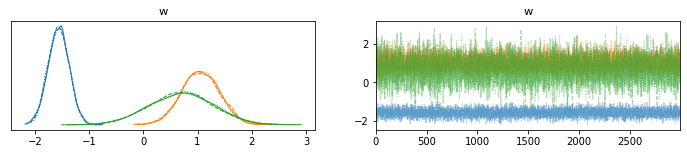

In [ ]:
az.plot_trace(trace)

In [ ]:
for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3), sep=' ')

w [1. 1. 1.]


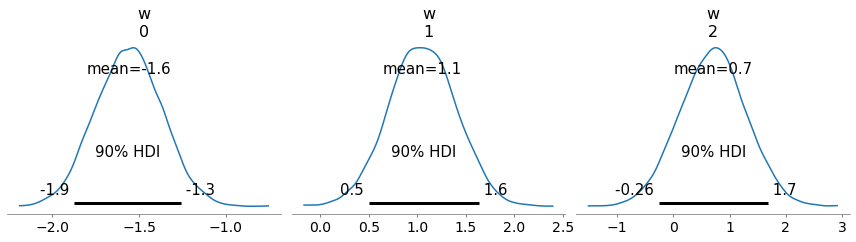

In [ ]:
fig,ax = plt.subplots(figsize=(12, 3.5), ncols=3)
az.plot_posterior(trace, hdi_prob=0.9,ax=ax)
plt.tight_layout()

In [ ]:
# 検証用データの作成
x_linspace = np.linspace(-5, 5, 10)
X1, X2 = np.meshgrid(x_linspace, x_linspace)
X_new = np.concatenate([X1.ravel()[:,np.newaxis], X2.ravel()[:,np.newaxis]], axis=1)
# バイアスの次元を追加
X_new_add_bias = np.concatenate([X_new,  np.ones(100)[:,np.newaxis]], axis=1)

with model:
    # 検証用データをモデルへ入力
    pm.set_data({"x": X_new_add_bias})
    # 予測分布からサンプリング
    pred = pm.sample_posterior_predictive(trace, samples=1000, random_seed=1)

y_pred_samples = pred['y']

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
Y_10_pred = np.percentile(y_pred_samples, 10, axis=0).reshape(10,10)
Y_25_pred = np.percentile(y_pred_samples, 25, axis=0).reshape(10,10)
Y_50_pred = np.percentile(y_pred_samples, 50, axis=0).reshape(10,10)
Y_75_pred = np.percentile(y_pred_samples, 75, axis=0).reshape(10,10)
Y_90_pred = np.percentile(y_pred_samples, 90, axis=0).reshape(10,10)

In [ ]:
cmap = plt.get_cmap("tab10")

def make_3Dplot(ax, elev, azim):
    surf1 = ax.plot_surface(X1, X2, Y_10_pred, alpha=0.3, color=cmap(7.5),label='10%')
    surf2 = ax.plot_surface(X1, X2, Y_25_pred, alpha=0.3, color=cmap(6),label='25%')
    surf3 = ax.plot_surface(X1, X2, Y_50_pred, alpha=0.3, color=cmap(5),label='50%')
    surf4 = ax.plot_surface(X1, X2, Y_75_pred, alpha=0.3, color=cmap(4),label='75%')
    surf5 = ax.plot_surface(X1, X2, Y_90_pred, alpha=0.3, color=cmap(2.5),label='90%')
    ax.scatter(x_data[:,0], x_data[:,1], y_data, alpha=1.0, color='black', s=40)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("x1", fontsize=16)
    ax.set_ylabel("x2", fontsize=16)
    ax.set_zlabel("y", fontsize=16)

    surf1._facecolors2d = surf1._facecolors3d
    surf1._edgecolors2d = surf1._edgecolors3d
    surf2._facecolors2d = surf2._facecolors3d
    surf2._edgecolors2d = surf2._edgecolors3d 
    surf3._facecolors2d = surf3._facecolors3d
    surf3._edgecolors2d = surf3._edgecolors3d
    surf4._facecolors2d = surf4._facecolors3d
    surf4._edgecolors2d = surf4._edgecolors3d
    surf5._facecolors2d = surf5._facecolors3d
    surf5._edgecolors2d = surf5._edgecolors3d
    ax.legend()

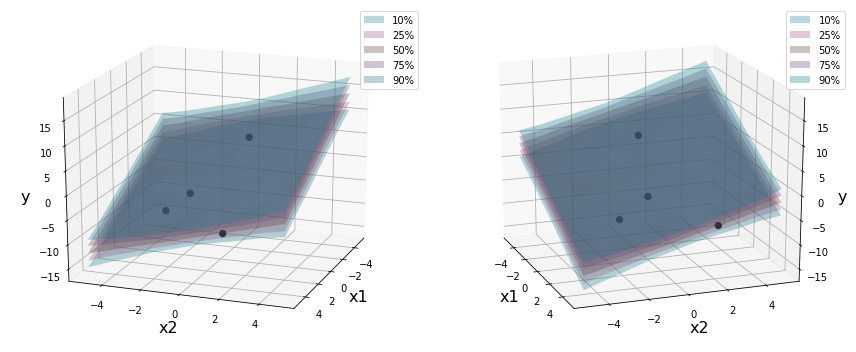

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
make_3Dplot(ax, 20, 20)

# 別角度から見えるように角度を変えて可視化
ax = fig.add_subplot(122, projection='3d')
make_3Dplot(ax, 20, -20)
plt.tight_layout();

In [ ]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.2.2
scipy     : 1.4.1
numpy     : 1.21.6
IPython   : 5.5.0
pandas    : 1.3.5
arviz     : 0.12.1
pymc3     : 3.11.4
seaborn   : 0.11.2

